# Study of Reinforcement Learning based on the [course](https://www.udemy.com/course/practical-ai-with-python-and-reinforcement-learning)

## Libraries
- [Gymnasium](https://gymnasium.farama.org/) 

## Q-Learning [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

In [ ]:
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install ipympl > /dev/null 2>&1

!pip install swig==4.1.1
!pip install Box2D==2.3.2
!pip install box2d-kengz==2.3.3
!pip install pygame==2.2.0
!pip install ale_py==0.8.1
!pip install pyglet==1.5.11

!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install --upgrade AutoROM
!AutoROM --accept-license
!pip install gymnasium[atari,accept-rom-license]==0.28.1

!wget http://www.atarimania.com/roms/Roms.rar
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul

!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install matplotlib > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [1]:
import io
import time
import numpy as np
import random
import math
import uuid
import glob
import base64
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt

from gymnasium import logger as gymlogger
from gymnasium.wrappers.record_video import RecordVideo
from gymnasium.utils import play
from IPython.display import HTML
from IPython import display as ipythondisplay

gymlogger.set_level(40) # error only
%matplotlib inline

In [2]:
from IPython.display import clear_output

def show_environment(array):
    plt.axis("off")
    plt.imshow(environment)
    plt.show()

## Just testing random actions to "feel" the environment

## Action Space

The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

- 0: Push cart to the left
- 1: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

## Observation Space

The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

|Num|Observation|Min|Max|
|--|--|--|--|
|0|Cart Position|-4.8|4.8|
|1|Cart Velocity|-Inf|Inf|
|2|Pole Angle|~ -0.418 rad (-24°)|~ 0.418 rad (24°)|
|3|Pole Angular Velocity|-Inf|Inf|

Reference:

[Cart Pole - Gymnasium](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

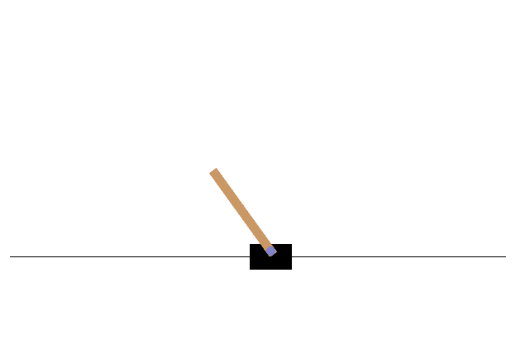

In [3]:
env_name = "CartPole-v1"
env = gym.make(env_name, render_mode="rgb_array")
env.reset()

for step in range(100):
    environment = env.render()
    show_environment(environment)
    action = env.action_space.sample() # 0 or 1
    env.step(action)
    time.sleep(0.02)
    clear_output(wait=True)
env.close()

In [4]:
env.reset()

for step in range(5):
    action = env.action_space.sample() # 0 or 1
    state, reward, term, trunc, info = env.step(action)
    print(state)
env.close()

[-0.03623433 -0.2328012   0.00769793  0.27960843]
[-0.04089036 -0.4280321   0.0132901   0.5747093 ]
[-0.049451   -0.23309898  0.02478429  0.28624257]
[-0.05411298 -0.03833909  0.03050914  0.00147831]
[-0.05487976 -0.233885    0.0305387   0.30362898]


Because this environment has continuous space, we have to transform the continuous values to discrete to store in the Q-Table (because with continuous space, we would have to have an infine number of values to hold), below the table with the configurations:

|Num|Observation|Min|Max|
|--|--|--|--|
|0|Cart Position|-4.8|4.8|
|1|Cart Velocity|-Inf|Inf|
|2|Pole Angle|~ -0.418 rad (-24°)|~ 0.418 rad (24°)|
|3|Pole Angular Velocity|-Inf|Inf|

In [5]:
def create_bins(num_bins_per_obs=10):
    bins_cart_position = np.linspace(-4.8, 4.8, num_bins_per_obs)
    bins_cart_velocity = np.linspace(-5, 5, num_bins_per_obs)
    bins_pole_angle = np.linspace(-0.418, 0.418, num_bins_per_obs)
    bins_pole_angular_velocity = np.linspace(-5, 5, num_bins_per_obs)
    bins = np.array([bins_cart_position, 
                     bins_cart_velocity, 
                     bins_pole_angle, 
                     bins_pole_angular_velocity])
    return bins

In [6]:
NUM_OF_BINS = 10
BINS = create_bins(NUM_OF_BINS)
print(f"Bins for Cart Position: {BINS[0]}")
print(f"Bins for Cart Velocity: {BINS[1]}")
print(f"Bins for Pole Angle: {BINS[2]}")
print(f"Bins for Pole Angular Velocity : {BINS[3]}")

Bins for Cart Position: [-4.8        -3.73333333 -2.66666667 -1.6        -0.53333333  0.53333333
  1.6         2.66666667  3.73333333  4.8       ]
Bins for Cart Velocity: [-5.         -3.88888889 -2.77777778 -1.66666667 -0.55555556  0.55555556
  1.66666667  2.77777778  3.88888889  5.        ]
Bins for Pole Angle: [-0.418      -0.32511111 -0.23222222 -0.13933333 -0.04644444  0.04644444
  0.13933333  0.23222222  0.32511111  0.418     ]
Bins for Pole Angular Velocity : [-5.         -3.88888889 -2.77777778 -1.66666667 -0.55555556  0.55555556
  1.66666667  2.77777778  3.88888889  5.        ]


To transform the continuous space in discrete, we will use the function `np.digitize(x, bins)`, folow the example below:

In [7]:
demo_bins = np.array([0, 2, 4, 6, 8, 10])
demo_datas = np.array([0, 1.9, 2, 3.9, 4, 5.9, 6, 7.9, 8, 9.9, 10])
inds = np.digitize(demo_datas, demo_bins)
print(inds)
for i in range(demo_bins.size):
    print(demo_bins[inds[i]-1], "<=", demo_datas[i], "<", demo_bins[inds[i]])

[1 1 2 2 3 3 4 4 5 5 6]
0 <= 0.0 < 2
0 <= 1.9 < 2
2 <= 2.0 < 4
2 <= 3.9 < 4
4 <= 4.0 < 6
4 <= 5.9 < 6


In [8]:
def discretize_observation(observations, bins):
    binned_observations = []
    for i, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
    return tuple(binned_observations)

In [9]:
observations, info = env.reset()
print(f"Cart Position: {observations[0]}")
print(f"Cart Velocity: {observations[1]}")
print(f"Pole Angle: {observations[2]}")
print(f"Pole Angular Velocity : {observations[3]}")

Cart Position: -0.006243875250220299
Cart Velocity: -0.022258570417761803
Pole Angle: 0.033783406019210815
Pole Angular Velocity : -0.007537125144153833


It's all 5 because the cart starts and the middle, an all it's values are in the middle:

In [10]:
mapped_observation = discretize_observation(observations, BINS)
mapped_observation

(5, 5, 5, 5)

In [11]:
q_table_shape = (NUM_OF_BINS, NUM_OF_BINS, NUM_OF_BINS, NUM_OF_BINS, env.action_space.n)
q_table_shape

(10, 10, 10, 10, 2)

In [12]:
q_table = np.zeros(q_table_shape)
q_table.shape

(10, 10, 10, 10, 2)

## Q-Table implementation of Q-Learning algorithm

- State is the full representation of the environment, and observation is a partial information of the state usually, in the gym library, they are interchangeable terms.

- **Epochs**: How many times the agent plays the game
- **Alpha**: Learning rate - To low, the agent can be slow to train, to high, it will overshot the learning function
- **Gamma**: Discount factor - We want the reward now, instead of the future
- **Decay Rate/Epsilon Reduce**: The rate that we update the epsilon to increase exploitation along the time, in the begging, we will explore a lot
- **Epsilon**: Multi armed bandit concept (Epsilon-Greedy) - Exploration vs Exploitation trade-off

In [13]:
EPOCHS = 30_000
ALPHA = 0.8
GAMMA = 0.9
epsilon = 1.0
BURN_IN = 1
EPSILON_END = 15_000
EPSILON_REDUCE = 0.0001

In [14]:
def epsilon_greedy_action_selection(env, epsilon, q_table, discrete_state):
    random_value = np.random.random()
    if random_value < epsilon:  # Exploration
        # action = env.action_space.sample()
        # or
        action = np.random.randint(0, env.action_space.n)
    else:  # Exploitation
        action = np.argmax(q_table[discrete_state])
    return action

In [15]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    # Q(s, a) <- Q(s, a) + alpha[R(s, a) + gamma maxQ(s', a') - Q(s, a)]
    return old_q_value + ALPHA*(reward + GAMMA * next_optimal_q_value - old_q_value)

In [16]:
# Another way to reduce the epsilon (increase the exploitation over time)
def reduce_epsilon(epoch, epsilon):
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon -= EPSILON_REDUCE
    return epsilon

In [17]:
MIN_POSITION = -4.8
MAX_POSITION = 4.8
MIN_ANGLE = -0.418
MAX_ANGLE = 0.418

def get_reward(state, done, points, reward, threshold=150):
    if state[0] <= MIN_POSITION or state[0] >= MAX_POSITION:
        reward -= 50
    
    if state[2] <= MIN_ANGLE or state[2] >= MAX_ANGLE:
        reward -= 50
    
    if done and points < threshold:
        reward -= 200
    return reward

Examples of output:
- discretized_state + (action,) = (5, 5, 5, 5, 0)
- new_discretized_state = (5, 5, 6, 6)
- next_optimal_q_value = \[0.8 0. ]
- q_table\[new_discretized_state] = 0.8

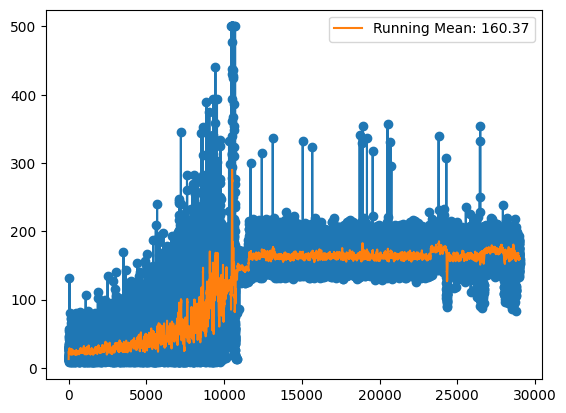

In [18]:
# In case you run on linux or macOS you can see the interactive graph
# %matplotlib notebook

log_interval = 1000
render_interval = 2000

##############################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
##############################

# For plotting
points_log = []
mean_points_log = []
epochs = []

for epoch in range(EPOCHS):

    state, info = env.reset()
    # From continous state/observation to discrete state/observation
    discretized_state = discretize_observation(state, BINS)
    done = False
    points = 0
    epochs.append(epoch)
    
    while not done:
        
        action = epsilon_greedy_action_selection(env, epsilon, q_table, discretized_state)
        new_state, reward, term, trunc, info = env.step(action)
        new_discretized_state = discretize_observation(new_state, BINS)
        done = term or trunc
                
        reward = get_reward(new_state, done, points, reward)
        
        # Old Q-Value (current)
        old_q_value = q_table[discretized_state + (action,)]
        
        # Find optimal Q-Value = max Q(s', a')
        next_optimal_q_value = np.max(q_table[new_discretized_state])

        # Compute Next Q-Value
        next_q_value = compute_next_q_value(old_q_value, reward, next_optimal_q_value)

        # Update Q-Table
        q_table[discretized_state + (action,)] = next_q_value
        
        # new state is now the state, so s' now is s
        discretized_state = new_discretized_state
        
        points += 1

    # Increase exploitation over time
    epsilon = reduce_epsilon(epoch, epsilon)
    points_log.append(points)
    running_mean = round(np.mean(points_log[-30:]), 2)
    mean_points_log.append(running_mean)

    ############### Plot the points and running mean ###############
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, points_log)
        ax.plot(epochs, points_log)
        ax.plot(epochs, mean_points_log, label=f"Running Mean: {running_mean}")
        plt.legend()
        fig.canvas.draw()
    ################################################################
env.close()

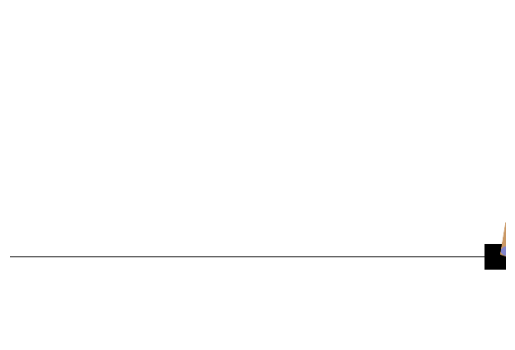

In [21]:
state, info = env.reset()
# From continous state/observation to discrete state/observation
discretized_state = discretize_observation(state, BINS)
rewards = 0
for _ in range(1000):
    environment = env.render()
    show_environment(environment)
    action = np.argmax(q_table[discretized_state])
    state, reward, term, trunc, info = env.step(action)
    discretized_state = discretize_observation(state, BINS)
    rewards += 1
    clear_output(wait=True)
    time.sleep(0.01)
    if term or trunc:
        break
env.close()

In [20]:
print(f"You got {rewards} points!")

You got 145 points!
